In [16]:
%matplotlib inline

In [1]:
from pathlib import Path

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.table as mtable
import matplotlib.cm as mcm

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import geopandas as gpd
from blume.table import table



paper_path = Path('../../paper/figures/')

slide_path = Path('../../slides/figures/intro/')
proposal_path = Path('../../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
ny = pd.read_csv("nydata")

In [3]:
ny['TAVG'] = (ny['DATA_VALUE'].astype(float)/10) *(9/5) + 32

In [4]:
ny['DATES'] = pd.to_datetime(ny['DATE'])

In [5]:
nymap = ny.groupby('NAME').agg({'TAVG':'std', 'LATITUDE':'mean', 'LONGITUDE':'mean'})

In [6]:
nygdf = gpd.GeoDataFrame(nymap['TAVG'],  geometry=gpd.points_from_xy(nymap['LONGITUDE'], nymap['LATITUDE']))

In [7]:
ny['TEMP'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")

In [8]:
dfs = ny[['DATE', 'LATITUDE', 'LONGITUDE', 'TEMP', 'NAME']].sort_values(by='DATE').head(10)

In [9]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
nystate = gpd.read_file(states_shp)

In [10]:
ny['TAVG'].describe()

count    1218.000000
mean       30.779310
std        10.682003
min        -1.480000
25%        23.360000
50%        30.380000
75%        36.500000
max        63.680000
Name: TAVG, dtype: float64

In [11]:
cmap = mcm.RdBu_r
norm = mcolors.Normalize(vmin=25, vmax=35)

In [12]:
def plot_table(ax, dfs, ccolors):
    tab = mtable.table(ax, cellText=dfs.astype('str').values, cellLoc='center',
                   colLabels=dfs.columns, loc='center')
    #bbox=(0, 0, 1, 1))
    tab.auto_set_font_size(False)
    tab.set_fontsize('medium')
    tab.scale(1.25, 1.5)
    tab.auto_set_column_width(np.arange(len(dfs.columns)))
    for i, color in enumerate(ccolors):
        for j in range(len(dfs)+1):
            tab[(j,i)].get_text().set_color(color)
            tab[(j,i)].set_edgecolor("black")    
    
    ax.set(xticks=[], yticks=[], aspect='equal')
    ax.axis('off')
    ax.add_table(tab)
    return tab

In [13]:
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#800000', '#aaffc3', '#000075']

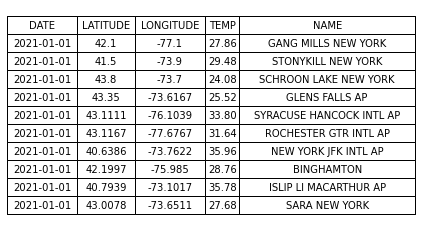

In [22]:
fig, ax = plt.subplots()
tab = plot_table(ax, dfs, ['black', 'black', 'black', 'black', 'black'])
fig.savefig(slide_path/"table.png", bbox_inches='tight')

In [ ]:
fig, axd = plt.subplot_mosaic([['table', 'map',],
                               ['table', 'time',]], 
                              constrained_layout=True, figsize=(12,4))
tab = plot_table(axd['table'], dfs, ['black', 'black', 'black', 'black', 'black'])

for i, (name, df) in enumerate(ny.groupby(['NAME'])):
    axd['time'].plot('DATES', 'TAVG', data=df, label=name, color=colors[i]),
    nygdf.loc[[name], 'geometry'].plot(ax=axd['map'], fc=cmap(norm(df['TAVG'].mean())), edgecolor=colors[i], markersize=50)
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k', zorder=-1)
ax1_divider = make_axes_locatable(axd['map'])
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
mpl.colorbar.ColorbarBase(cax1, cmap=cmap,norm=norm, orientation='vertical')


#arrows
arrow_kws = {'color':'#A50B5E', 'linewidth':2, 'mutation_scale':25}

xpos_map = mpatches.ConnectionPatch(xyA=(.4,.75), coordsA=axd['table'].transData,
                                     xyB=(-73.9, 41.75), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.25, angleB=180", 
                        connectionstyle="bar,armA=0.0, armB=0.0,angle=180,fraction=-0.2", **arrow_kws)
#fig.add_artist(xpos_map)

ypos_map = mpatches.ConnectionPatch(xyA=(.13,.75), coordsA=axd['table'].transData,
                                     xyB=(-74.2, 41.5), coordsB=axd['map'].transData,   
                         arrowstyle="-[,widthB=.25, angleB=180", 
                        connectionstyle="angle,angleA=90,angleB=180", **arrow_kws)
fig.add_artist(ypos_map)



fig.savefig(slide_path/"time.png")



axd['map'].set_aspect('equal')
axd['map'].axis('off')

In [ ]:
fig, axd = plt.subplot_mosaic([['tab1','tab2', 'time']], gridspec_kw={'width_ratios':[1,1,2]},
                              constrained_layout=True, figsize=(9,3))

tab = plot_table(axd['tab1'], dfs[['DATE', 'TAVG']], ['k', 'tab:blue'])
tab2 = plot_table(axd['tab2'], dfs[['DATE', 'TAVG2']], ['k','tab:orange'])
tab2[(0,1)].get_text().set_text('TAVG')
axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
axd['time'].plot('DATES', 'TAVG2', data=nyjfk, color='tab:orange')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_ylabel("temperature (°F)")

for y in [.075, .25, .42, .58, .75]:
    con_ft = mpatches.ConnectionPatch(xyA=(.85,y), coordsA=axd['tab1'].transData,
                            xyB=(.65, y), coordsB=axd['tab2'].transData,   
                             arrowstyle="fancy", mutation_scale=60, 
                            facecolor='#A50B5E', edgecolor='black', alpha=.5)
    fig.add_artist(con_ft)
    
for (i, (d, t1, t2)) in nyjfk[['DATES', 'TAVG', 'TAVG2']].iloc[::2].iterrows():
    a1 = mpatches.FancyArrowPatch((d, t1), (d,t2), arrowstyle="->",  
                                  linestyle=None, mutation_scale=15, color='#A50B5E')
    axd['time'].add_artist(a1)
fig.savefig(paper_path/"equivariance.png")

In [ ]:
table = np.array([["sun", 1], ["clouds", 4], ['rain', 2], ['lightning', 3], ['storm', 2]])

In [ ]:
fig, axd = plt.subplot_mosaic([['tab','plot'], ['tab', 'bar']], gridspec_kw={'width_ratios':[1,1]}, 
                              constrained_layout=True, figsize=(6,2))

tab = axd['tab'].table(cellText=table.astype('str'), bbox=(0, 0, 1, 1))
tab.set_fontsize('xx-large')
axd['tab'].set(xticks=[], yticks=[], aspect='equal')
axd['plot'].plot(table[:,0], table[:,1].astype(int), color='tab:green')
axd['bar'].bar(table[:,0], table[:,1].astype(int), color='tab:green')
for n in ['bar', 'plot']:
    #axd[n].set_ylim(0,4.1)
    axd[n].set_ylabel("frequency")
    axd[n].xaxis.set_tick_params(rotation=0)
    axd[n].set_yticks([0, 2.5, 5])
    axd[n].set_yticklabels(['0', '2.5', '5'])
axd['bar'].set_ylim(0,5)
axd['plot'].set_ylim(0, 5)

fig.savefig(paper_path/"continuity.png")

In [ ]:
fig, axd = plt.subplot_mosaic([ ['tab','plot', 'plot'], 
                                ['tab', 'bar', 'bar'], 
                                ['tab1','tab2', 'time'], 
                              
                              ], gridspec_kw={'width_ratios':[1,1,2], 'height_ratios':[1,1,2]},
                              constrained_layout=True, figsize=(6,6))

tab = plot_table(axd['tab1'], dfs[['DATE', 'TAVG']], ['k', 'tab:blue'])
tab2 = plot_table(axd['tab2'], dfs[['DATE', 'TAVG2']], ['k','tab:orange'])
tab2[(0,1)].get_text().set_text('TAVG')
axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
axd['time'].plot('DATES', 'TAVG2', data=nyjfk, color='tab:orange')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_ylabel("temperature (°F)")

for y in [.075, .25, .42, .58, .75]:
    con_ft = mpatches.ConnectionPatch(xyA=(.85,y), coordsA=axd['tab1'].transData,
                            xyB=(.65, y), coordsB=axd['tab2'].transData,   
                             arrowstyle="fancy", mutation_scale=60, 
                            facecolor='#A50B5E', edgecolor='black', alpha=.5)
    fig.add_artist(con_ft)
    
for (i, (d, t1, t2)) in nyjfk[['DATES', 'TAVG', 'TAVG2']].iloc[::2].iterrows():
    a1 = mpatches.FancyArrowPatch((d, t1), (d,t2), arrowstyle="->",  
                                  linestyle=None, mutation_scale=15, color='#A50B5E')
    axd['time'].add_artist(a1)
    

tab = axd['tab'].table(cellText=table.astype('str'), bbox=(0, 0, 1, 1))
tab.set_fontsize('xx-large')
axd['tab'].set(xticks=[], yticks=[], aspect='equal')
axd['plot'].plot(table[:,0], table[:,1].astype(int), color='tab:green')
axd['bar'].bar(table[:,0], table[:,1].astype(int), color='tab:green')
for n in ['bar', 'plot']:
    #axd[n].set_ylim(0,4.1)
    axd[n].set_ylabel("frequency")
    axd[n].xaxis.set_tick_params(rotation=0)
    axd[n].set_yticks([0, 2.5, 5])
    axd[n].set_yticklabels(['0', '2.5', '5'])
axd['bar'].set_ylim(0,5)
axd['plot'].set_ylim(0, 5)
fig.savefig(paper_path/"structure.png")